In [3]:
import cashladder

In [4]:
import lusid
import lusid.models as models
import os
from msrest.authentication import BasicTokenAuthentication

api_url = os.getenv("FBN_LUSID_API_URL")
api_token = {"access_token": os.environ["ACCESS_TOKEN"]}
credentials = BasicTokenAuthentication(api_token)
client = lusid.LUSIDAPI(credentials, api_url)

import uuid
from datetime import datetime
from datetime import timedelta
import pytz
from collections import namedtuple
            
def build_transaction(transaction_spec):
    return models.TransactionRequest(
        transaction_id=str(uuid.uuid4()),
        type="Buy",
        instrument_uid=transaction_spec.id,
        transaction_date=transaction_spec.trade_date,
        settlement_date=transaction_spec.trade_date + timedelta(days=2),
        units=100,
        transaction_price=models.TransactionPrice(transaction_spec.price),
        total_consideration=models.CurrencyAndAmount(100 * transaction_spec.price, transaction_spec.currency),
        source="Client")

TransactionSpec = namedtuple('TransactionSpec', 'id price trade_date settlement_date currency')

def create_portfolio_with_transactions(scope, name, date, trades):
    scope = "finbourne"
    guid = str(uuid.uuid4())
    portfolio_code = "id-{0}".format(guid)
    effective_date = datetime(2018, 1, 1, tzinfo=pytz.utc)
    
    request = models.CreateTransactionPortfolioRequest(
        "portfolio-{0}".format(guid),
        "id-{0}".format(guid),
        base_currency="GBP",
        created=effective_date
    )

    #   create the portfolio
    result = client.create_portfolio(scope, request)
    portfolio_id = result.id.code

    #   build and add trades
    new_transactions = list(map(build_transaction, trades))
    add_transactions_result = client.upsert_transactions(scope, portfolio_id, new_transactions)
    
    return portfolio_code

In [5]:
# create instruments

instruments = [
    {"Figi": "BBG000C6K6G9", "Name": "VODAFONE GROUP PLC"},
    {"Figi": "BBG000C04D57", "Name": "BARCLAYS PLC"},
    {"Figi": "BBG000FV67Q4", "Name": "NATIONAL GRID PLC"},
    {"Figi": "BBG000BF0KW3", "Name": "SAINSBURY (J) PLC"},
    {"Figi": "BBG000BF4KL1", "Name": "TAYLOR WIMPEY PLC"}
]

figis_to_create = { i["Figi"]:models.UpsertInstrumentRequest(i["Name"], {"Figi": i["Figi"]}) for i in instruments }

upsert_response = client.upsert_instruments(figis_to_create)

if len(upsert_response.failed) != 0:
    raise Exception(upsert_response.failed)

ids = client.get_instruments("Figi", [i["Figi"] for i in instruments])

instrument_ids = [i.lusid_instrument_id for i in ids.values.values()]

In [6]:
from datetime import datetime

effective_date = datetime(2018, 1, 1, tzinfo=pytz.utc)
trades = [
    TransactionSpec(instrument_ids[0], 101, datetime(2018, 1, 1, tzinfo=pytz.utc), datetime(2018, 1, 4, tzinfo=pytz.utc), "GBP"),       
    TransactionSpec(instrument_ids[0], 102, datetime(2018, 1, 2, tzinfo=pytz.utc), datetime(2018, 1, 5, tzinfo=pytz.utc), "GBP"),
    TransactionSpec(instrument_ids[0], 103, datetime(2018, 1, 3, tzinfo=pytz.utc), datetime(2018, 1, 6, tzinfo=pytz.utc), "GBP"),
    TransactionSpec(instrument_ids[0], 104, datetime(2018, 1, 1, tzinfo=pytz.utc), datetime(2018, 1, 4, tzinfo=pytz.utc), "USD"),
    TransactionSpec(instrument_ids[1], 105, datetime(2018, 1, 2, tzinfo=pytz.utc), datetime(2018, 1, 5, tzinfo=pytz.utc), "USD"),
    TransactionSpec(instrument_ids[1], 106, datetime(2018, 1, 3, tzinfo=pytz.utc), datetime(2018, 1, 6, tzinfo=pytz.utc), "USD"),
    TransactionSpec(instrument_ids[2], 107, datetime(2018, 1, 1, tzinfo=pytz.utc), datetime(2018, 1, 4, tzinfo=pytz.utc), "EUR"),
    TransactionSpec(instrument_ids[3], 108, datetime(2018, 1, 2, tzinfo=pytz.utc), datetime(2018, 1, 5, tzinfo=pytz.utc), "EUR"),      
    TransactionSpec(instrument_ids[1], 109, datetime(2018, 1, 3, tzinfo=pytz.utc), datetime(2018, 1, 6, tzinfo=pytz.utc), "EUR"),
    
]

created_code = create_portfolio_with_transactions(scope="finbourne", name="demo", date=effective_date, trades=trades)

In [7]:
import cashladder as c 
cl_date = '2018-01-04'
c.cash_ladder(date=cl_date, scope='finbourne',portfolio=created_code)

settlement_date                           2018-01-04
instrument_uid sort holding_type                    
CCY_EUR        1.0  Opening Cash Balance    -32400.0
               5.0  EUR Summary             -32400.0
CCY_GBP        1.0  Opening Cash Balance    -30600.0
               5.0  GBP Summary             -30600.0
CCY_USD        1.0  Opening Cash Balance    -31500.0
               5.0  USD Summary             -31500.0

In [8]:
acl = c.alt_cash_ladder(date=cl_date,scope='finbourne',portfolio=created_code)
chart_data = acl[['Currency','Cash Date','balance']].drop_duplicates(['Currency','Cash Date'],keep='last')
chart_data = chart_data.pivot(index="Currency", columns="Cash Date", values="balance").fillna(0)

In [9]:
chart_data

Cash Date,2018-01-04
Currency,
CCY_EUR,-32400.0
CCY_GBP,-30600.0
CCY_USD,-31500.0


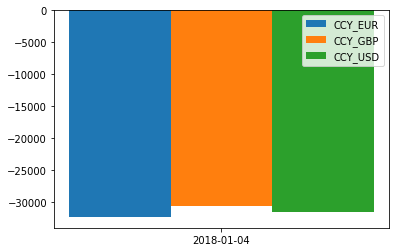

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

ind = np.arange(chart_data.columns.size)
width = 0.1

fig, ax = plt.subplots()

for ccy, x in zip(chart_data.index, [-.2, 0, .2]):
    ax.bar(ind + x/2, chart_data.loc[ccy,:].asobject, width, label=ccy)
    
ax.set_xticks(ind)
ax.set_xticklabels(chart_data.columns.values)
ax.legend()

plt.show()